#### **[STEP 1] 구글드라이브 마운트**

In [ ]:
# google의 colab 모듈에서 drive 불러오기
from google.colab import drive  
drive.mount("/content/drive")

# 현재 실행 경로(Current directory) 변경
import os
os.chdir("/content/drive/MyDrive")

# [내 드라이브] 에 [파이썬으로 레벨 업] 폴더 생성
try:
    os.mkdir("파이썬으로 레벨 업")
except FileExistsError:
    pass

Mounted at /content/drive


#### **[STEP 2] 패키지 불러오기**

In [ ]:
# 사용할 패키지 불러오기
import os
import requests
import pandas as pd  # pandas 패키지를 pd 라는 이름으로 불러오기
import networkx as nx  # networkx 패키지를 nx 라는 이름으로 불러오기
import matplotlib.pyplot as plt  # matplotlib의 pyplot 모듈을 plt 라는 이름으로 불러오기
import matplotlib.font_manager as fm  # matplotlib의 font_manager 모듈을 fm 이라는 이름으로 불러오기

#### **[STEP 3] Matplotlib 폰트 설치하기**

In [ ]:
# 나눔 폰트 다운로드
os.system("apt-get install -y fonts-nanum")

# 파일 경로 설정하기
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

# 폰트 추가하기
new_font = fm.FontEntry(fname=font_path, name="나눔고딕")
fm.fontManager.ttflist.append(new_font)

# Matplotlib Parameters 업데이트
plt.rcParams.update({'font.size': 10, 'font.family': '나눔고딕'})

#### **[STEP 4] CSV 파일 조작하기**

In [ ]:
csv_path = "파이썬으로 레벨 업/data.csv"

def get_csv_data(**kwargs) -> dict:
    # CSV 열 데이터 가져오기
    def get_column_data(add:int) -> list:
        values = csv_df[csv_columns[name_index + add]].tolist()
        return values

    # 문항별 결과 처리
    def get_values(question:int, result:dict):
        values = get_column_data(question + 1)

        for idx_answer, answer in enumerate(values):
            if type(answer) is not str:
                answer = ""

            name = csv_data["names"][idx_answer]
            names = answer.split(", ")

            try:
                result[name] += names
            except:
                result[name] = names

            result[name] = list(set(result[name]))

    # 카테고리에 해당하는 문항 일괄 처리
    def get_category_values(groups:list) -> dict:
        result = {}

        for idx, question in enumerate(groups):
            get_values(question, result)

        return result

    # CSV 파일 불러오기
    csv_df = pd.read_csv(csv_path)
    csv_columns = csv_df.columns.tolist()
    name_index = csv_columns.index('2. 이름을 입력해주세요.')

    # CSV 데이터 변환 및 저장하기
    csv_data = dict()
    csv_data['names'] = get_column_data(add=0)
    csv_data['gender'] = get_column_data(add=1)

    for key, content in kwargs.items():
        csv_data[key] = get_category_values(content)

    return csv_data

#### **[STEP 5] NetworkX 그래프 그리기**

In [ ]:
def draw_graph(csv_data, **kwargs):
    # Node의 색상 불투명도 설정
    def plt_rgba(r:int, g:int, b:int, a:int):
        return (r/255, g/255, b/255, a)

    # Node의 크기를 가중치에 따라 설정
    def set_node_size(degree):
        node_resized = list()
        base_size = 80

        for item in degree:
            size = base_size * (item[1] * 3 + 1)
            node_resized.append(size)

        return node_resized

    # Node의 색상을 [성별 및 선택 받은 수]에 따라 설정
    def set_node_color(degree):
        # 필요한 변수 설정
        node_color = []
        degree_values = [item[1] for item in degree]
        degree_values.sort(reverse=True)
        
        # [성별 및 선택 받은 수] 에 따라 Node의 색 설정
        for item in degree:
            name = item[0]
            index = csv_data["names"].index(name)
            data = csv_data["gender"][index]

            # [선택 받은 수] 에 따라 Node의 불투명도 변경
            alpha = 0
            if item[1] in degree_values[0:2]:
                alpha = 0.8
            elif item[1] in degree_values[2:5]:
                alpha = 0.5
            else:
                alpha = 0.2

            # [성별] 에 따라 Node의 색 결정
            if data == "남":
                color = plt_rgba(135, 206, 235, alpha)
            else:
                color = plt_rgba(255, 192, 203, alpha)

            node_color.append(color)

        return node_color

    # Edge의 색상을 [상호선택여부]에 따라 설정
    def set_egde_color(edge:list, content):
        edge = list(edge)

        edge_color = []
        for item in edge:
            from_name = item[0]
            to_name = item[1]

            alpha = 0.3

            # [상호선택여부] 가 참이면 불투명도 1로 설정
            if to_name != "":
                if from_name in content[to_name]:
                    alpha = 1

            color = plt_rgba(84, 183, 153, alpha)
            edge_color.append(color)

        return edge_color

    # plt 생성하기 (2x3 으로 이루어진 여섯 개의 plots)
    plt.subplots(2, 3, figsize=(20, 14))

    # Graph 그리기
    graph_idx = 1
    for category, content in kwargs.items():
        # Graph 위치 결정
        plt.subplot(2, 3, graph_idx)

        # Graph 제목
        plt.title(f"{category} 그래프", fontdict = {'fontsize' : 16, 'fontweight' : "bold"})

        # NetworkX 객체 생성
        G = nx.DiGraph()
        pos = nx.kamada_kawai_layout(G)
        degree = G.in_degree
        edge = G.edges()

        # Node 설정
        for name in csv_data['names']:
            G.add_node(name)

        # Edge 설정
        for from_name, to_names in content.items():
            for to_name in to_names:
                if to_name != "":
                    G.add_edge(from_name, to_name)

        # NetworkX 객체의 레이아웃 및 속성 정보 가져오기
        pos = nx.kamada_kawai_layout(G)
        degree = G.in_degree
        edge = G.edges()
        
        # NetworkX Graph 그리기
        G = nx.draw(G,
                    with_labels=True,
                    pos = pos,
                    node_color = set_node_color(degree),
                    node_size = set_node_size(degree),
                    edge_color = set_egde_color(edge, content),
                    font_family = "나눔고딕",
                    )

        # 다음 위치로 넘어가기
        graph_idx += 1

    # 마지막(여섯 번째) subplot의 axes(축) 지우기
    plt.delaxes(plt.subplot(2, 3, 6))

    # subplots의 여백 설정
    plt.subplots_adjust(wspace=0, hspace=0)

    return plt

#### **[STEP 6] 최종 그래프 그리기**

In [ ]:
# 문항별로 그룹화하기
csv_data = get_csv_data(인기지수=[1, 2],
                        위기지수=[3],
                        브레인지수=[4, 5],
                        미래확장지수=[6, 7, 8, 9],
                        버럭이지수=[10])

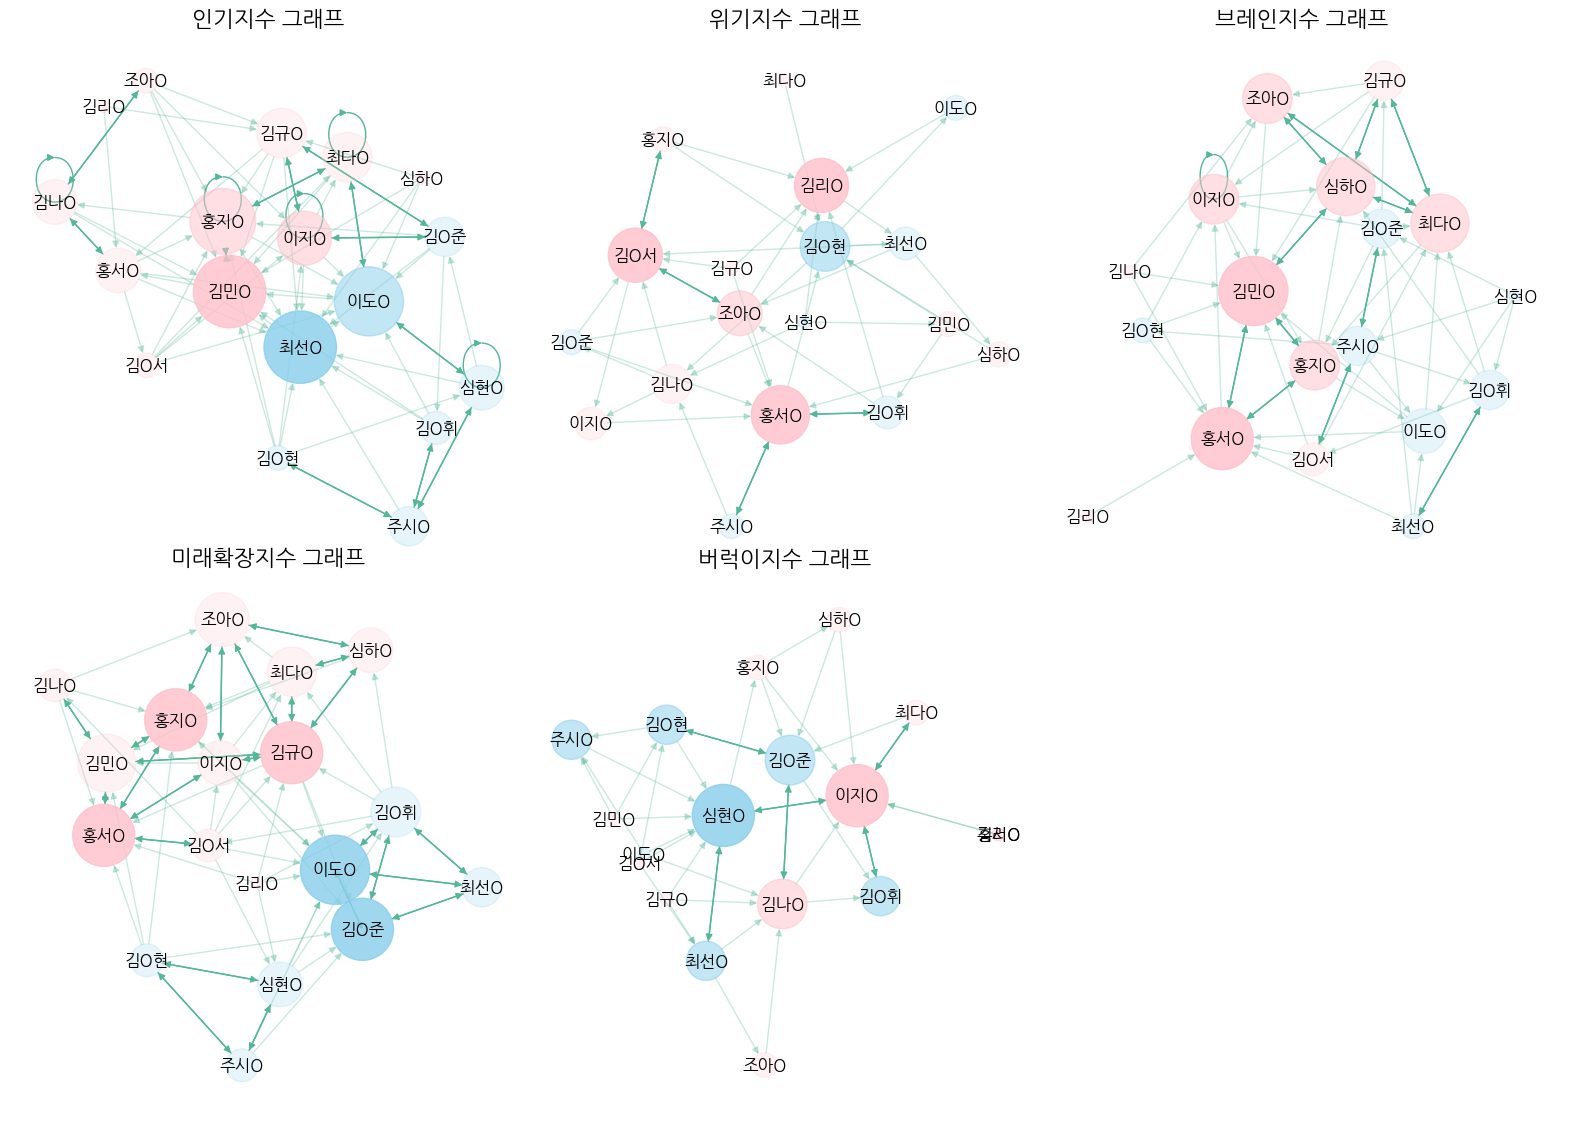

In [ ]:
plt = draw_graph(csv_data,
                 인기지수=csv_data["인기지수"],
                 위기지수=csv_data["위기지수"],
                 브레인지수=csv_data["브레인지수"],
                 미래확장지수=csv_data["미래확장지수"],
                 버럭이지수=csv_data["버럭이지수"])
plt.show()